In [17]:
import os

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import xarray as xr
import lmfit
import yaml

from sdm_eurec4a.visulization import set_custom_rcParams, symlog_from_array, handler_map_alpha, adjust_lightness_array
from sdm_eurec4a.identifications import (
    select_individual_cloud_by_id,
    match_clouds_and_cloudcomposite,
    match_clouds_and_dropsondes,
)
from sdm_eurec4a.reductions import shape_dim_as_dataarray
from sdm_eurec4a.pySD import probdists

from sdm_eurec4a.conversions import msd_from_psd

from sdm_eurec4a import RepositoryPath
from sdm_eurec4a.input_processing import transfer


In [18]:
plt.style.use("default")
default_colors = set_custom_rcParams()
dark_colors = adjust_lightness_array(default_colors, amount = 0.5)
from matplotlib import rc

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
rc("text", usetex=False)

# THE PATH TO THE SCRIPT DIRECTORY
script_dir = os.path.abspath("/home/m/m301096/repositories/sdm-eurec4a/scripts/CLEO/initalize")
print(script_dir)

# REPOSITORY_ROOT = Path(script_dir).parents[2]
REPOSITORY_ROOT = RepositoryPath("levante")()
print(REPOSITORY_ROOT)

fig_path = REPOSITORY_ROOT / Path(f"results/CLEO/create_input")
fig_path.mkdir(parents=True, exist_ok=True)


/home/m/m301096/repositories/sdm-eurec4a/scripts/CLEO/initalize
/home/m/m301096/repositories/sdm-eurec4a


In [19]:
plt.style.use("default")
default_colors = set_custom_rcParams()
from matplotlib import rc

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
rc("text", usetex=False)

# THE PATH TO THE SCRIPT DIRECTORY
script_dir = os.path.abspath("/home/m/m301096/repositories/sdm-eurec4a/scripts/CLEO/initalize")
print(script_dir)

# REPOSITORY_ROOT = Path(script_dir).parents[2]
REPOSITORY_ROOT = RepositoryPath("levante")()
print(REPOSITORY_ROOT)

fig_path = REPOSITORY_ROOT / Path(f"results/CLEO/create_input")
fig_path.mkdir(parents=True, exist_ok=True)

/home/m/m301096/repositories/sdm-eurec4a/scripts/CLEO/initalize
/home/m/m301096/repositories/sdm-eurec4a


### Load datasets


In [20]:

identified_clouds = xr.open_dataset(
   "/home/m/m301096/repositories/sdm-eurec4a/data/observation/cloud_composite/processed/identified_clouds/identified_clusters_rain_mask_5.nc"
)
# select only clouds which are between 800 and 1100 m
identified_clouds = identified_clouds.where(
    (identified_clouds.alt >= 700) & (identified_clouds.alt <= 1100)
    &(identified_clouds.vertical_extent < 100), drop=True
)

distance_IC_DS = xr.open_dataset(
    REPOSITORY_ROOT
    / Path(f"data/observation/combined/distance_relations/distance_dropsondes_identified_clusters_rain_mask_5.nc")
)

cloud_composite = xr.open_dataset(
    REPOSITORY_ROOT
    / Path(
        f"data/observation/cloud_composite/processed/cloud_composite_si_units.nc"
    )
)

drop_sondes = xr.open_dataset(
    REPOSITORY_ROOT
    / Path("data/observation/dropsonde/processed/drop_sondes.nc")
)

drop_sondes = drop_sondes.where(drop_sondes.alt <= 1500, drop = True)


# Add radii and altitude arrays to datasets

cloud_composite["radius_array"] = shape_dim_as_dataarray(da=cloud_composite["particle_size_distribution"], output_dim="radius")
drop_sondes["alt_array"] = shape_dim_as_dataarray(da=drop_sondes["air_temperature"], output_dim="alt")


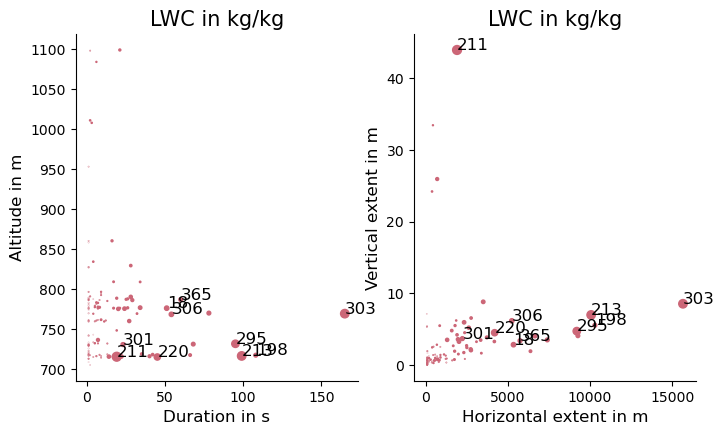

In [33]:
fig, axs = plt.subplots(1, 2)
axs[0].scatter(
    identified_clouds["duration"].dt.seconds,
    identified_clouds["alt"],
    identified_clouds["liquid_water_content"],
    marker = "o", linestyle = "None", color = default_colors[0])
axs[0].set_xlabel("Duration in s")
axs[0].set_ylabel("Altitude in m")
axs[0].set_title("LWC in kg/kg")


axs[1].scatter(
    identified_clouds["horizontal_extent"],
    identified_clouds["vertical_extent"],
    identified_clouds["liquid_water_content"],
    marker = "o", linestyle = "None", color = default_colors[0])

axs[1].set_xlabel("Horizontal extent in m")
axs[1].set_ylabel("Vertical extent in m")
axs[1].set_title("LWC in kg/kg")


for t in identified_clouds.sortby("liquid_water_content").time[-10:]:
    subdata = identified_clouds.sel(time = t)
    axs[0].annotate(subdata.cloud_id.data, (
        subdata.duration.dt.seconds,
        subdata.alt)
    )
    axs[1].annotate(subdata.cloud_id.data, (
        subdata["horizontal_extent"],
        subdata["vertical_extent"]
        )
    )
fig.savefig(fig_path / Path("cloud_properties.png"))

### Lets plot the PSD and Thermodynamic profiles for lets say three clouds to see differences



In [ ]:
identified_clouds.sortby("liquid_water_content").cloud_id[-10:]

 ### Create dictonary of input class for each cloud

In [37]:
chosen_id = 301
split_radius = 4.5e-5
subfig_path = fig_path / Path(f"cloud_{chosen_id}")
subfig_path.mkdir(parents=True, exist_ok=True)

cloud_information = dict(
            cloud_id = chosen_id,
            split_radius = split_radius,
            dropsonde_distance = dict(
                    max_spatial_distance=100,
                    max_temporal_distance="3h"),
            )

# select a single cloud
if chosen_id is not None:
    ds_cloud = select_individual_cloud_by_id(ds_clouds, chosen_id)
else:
    ds_cloud = ds_clouds

ds_cloudcomposite_with_zeros = match_clouds_and_cloudcomposite(
    ds_clouds=ds_cloud,
    ds_cloudcomposite=cloud_composite,
)

ds_dropsondes = match_clouds_and_dropsondes(
    ds_clouds=ds_cloud,
    ds_sonde=drop_sondes,
    ds_distance=distance_IC_DS,
    max_spatial_distance=100,
    max_temporal_distance=np.timedelta64(3, "h"),
)

# remove 0s
ds_cloudcomposite = ds_cloudcomposite_with_zeros.where(ds_cloudcomposite_with_zeros["particle_size_distribution"] != 0)



# Split data into cloud and rain

In [38]:


ds_lower = ds_cloudcomposite.sel(radius=slice(None, split_radius))
ds_rain = ds_cloudcomposite.sel(radius=slice(split_radius, None))

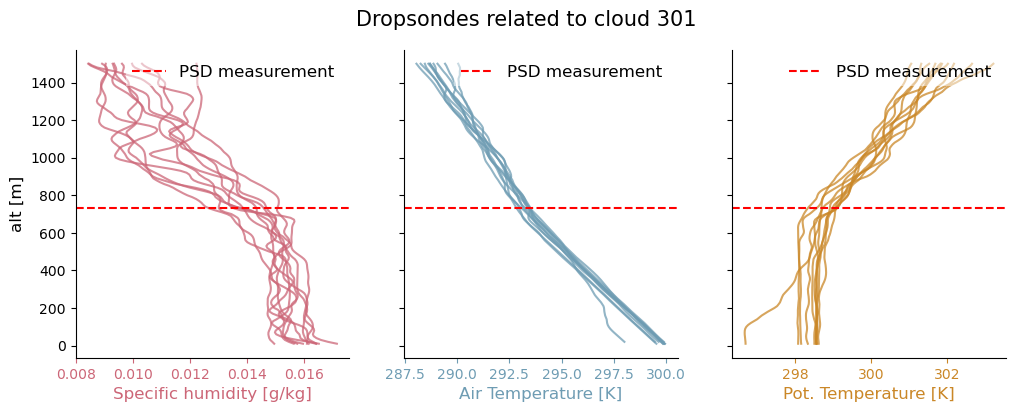

In [54]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 4), sharey=True)

scatter_style = dict(alpha=0.75)

ax_q, ax_ta, ax_theta = axs
# First plot
ax_q.plot(
    ds_dropsondes["specific_humidity"].T,
    ds_dropsondes["alt"].T,
    color=default_colors[0],
    # label="Spec. Hum.",
    **scatter_style,
)

ax_q.set_xlabel("Specific humidity [g/kg]")
ax_q.set_ylabel("alt [m]")
ax_q.xaxis.label.set_color(default_colors[0])  # Set the color of x-axis label
ax_q.tick_params(axis="x", colors=default_colors[0])  # Set the color of x-axis ticks

# Second plot on a new x-axis
ax_ta.plot(
    ds_dropsondes["air_temperature"].T,
    ds_dropsondes["alt"].T,
    color=default_colors[1],
    # label="Air Temperature",
    **scatter_style,
)

ax_ta.set_xlabel("Air Temperature [K]")
ax_ta.xaxis.label.set_color(default_colors[1])  # Set the color of x-axis label
ax_ta.tick_params(axis="x", colors=default_colors[1])  # Set the color of x-axis ticks

# Thrid plot on a new x-axis
ax_theta.plot(
    ds_dropsondes["potential_temperature"].T,
    ds_dropsondes["alt"].T,
    color=default_colors[2],
    # label="Pot. Temperature",
    **scatter_style,
)

ax_theta.set_xlabel("Pot. Temperature [K]")
ax_theta.xaxis.label.set_color(default_colors[2])  # Set the color of x-axis label
ax_theta.tick_params(axis="x", colors=default_colors[2])  # Set the color of x-axis ticks

for ax in axs:
    ax.axhline(ds_cloud.alt, color="r", linestyle="--", label="PSD measurement")
    ax.legend()

fig.suptitle(f"Dropsondes related to cloud {chosen_id}")
fig.savefig(subfig_path / Path("dropsonde_properties.png"))

In [40]:
psd_rain_fit = transfer.PSD_LnNormal()
psd_cloud_fit = transfer.PSD_LnNormal()

# Drizzle and cloud droplets
data = ds_rain.particle_size_distribution
radi2d = shape_dim_as_dataarray(da=data, output_dim="radius")

psd_rain_fit.update_individual_model_parameters(
    lmfit.Parameter(
        name = "geometric_means",
        min = data.radius.min().data,
        max = data.radius.max().data,
)
)

rain_model_result = psd_rain_fit.get_model().fit(
    data = data.data,
    radii = radi2d.data,
    params = psd_rain_fit.get_model_parameters(),
    nan_policy='omit'
)
psd_rain_fit.lmfitParameterValues_to_dict(
    rain_model_result.params
)


data = ds_lower.particle_size_distribution
radi2d = shape_dim_as_dataarray(da=data, output_dim="radius")
psd_model = psd_cloud_fit.get_model() 

cloud_model_result = psd_model.fit(
    data = data.data,
    radii = radi2d.data,
    params = psd_cloud_fit.get_model_parameters(),
    nan_policy='omit'
)
psd_cloud_fit.lmfitParameterValues_to_dict(
    cloud_model_result.params
)

psd_fit = psd_rain_fit + psd_cloud_fit

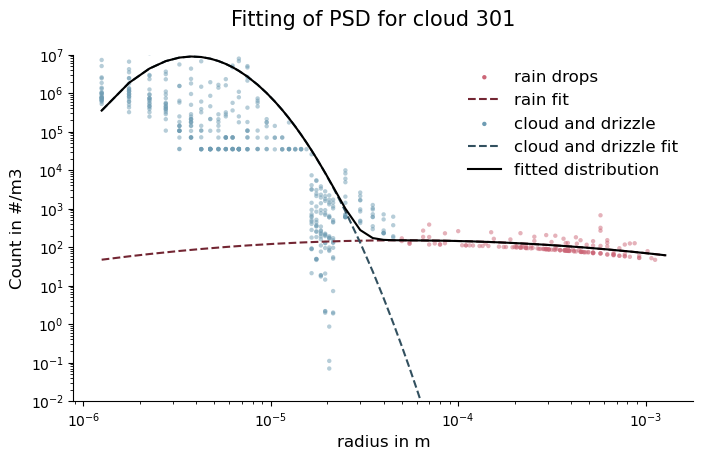

In [41]:
# plt.plot(fitted_model.eval_func(ds_cloudcomposite.radius))
style = dict(
    marker="o",
    edgecolor='none',
    s = 10,
    alpha=0.5,
)
fig, ax = plt.subplots(nrows =1, ncols =1)
ax.set_ylim(1e-2, 1e7)
ax.set_yscale("log")
ax.set_xscale("log")

ax.scatter(
    ds_rain.radius_array, 
    ds_rain.particle_size_distribution, 
    c=default_colors[0],
    label = "rain drops",
    **style)

ax.plot(
    ds_cloudcomposite.radius, 
    psd_rain_fit.eval_func(ds_cloudcomposite.radius),
    label = "rain fit",
    linestyle = "--",
    color = dark_colors[0])

ax.scatter(
    ds_lower.radius_array, 
    ds_lower.particle_size_distribution, 
    c=default_colors[1],
    label = "cloud and drizzle",
    **style)


ax.plot(
    ds_cloudcomposite.radius, 
    psd_cloud_fit.eval_func(ds_cloudcomposite.radius),
    label = "cloud and drizzle fit",
    linestyle = "--",
    color = dark_colors[1])

ax.plot(
    ds_cloudcomposite.radius, 
    psd_fit.eval_func(ds_cloudcomposite.radius),
    label = "fitted distribution",
    color = "k")

ax.legend(
    handler_map = handler_map_alpha()
)

ax.set_xlabel("radius in m")
ax.set_ylabel("Count in #/m3")


fig.suptitle(f"Fitting of PSD for cloud {chosen_id}")
fig.savefig(subfig_path / Path("fitted_psd.png"))


### Allowing a variable x_split

In [42]:
thermo_fit = dict(
    air_temperature = transfer.ThermodynamicSplitLinear(),
    specific_humidity = transfer.ThermodynamicSplitLinear(),
    potential_temperature = transfer.ThermodynamicSplitLinear(),
)


for var in thermo_fit:
    
    data = ds_dropsondes[var]
    alt2d = shape_dim_as_dataarray(da = data, output_dim = "alt")
    result = thermo_fit[var].get_model().fit(
        data = data.data,
        x = alt2d.data,
        nan_policy='omit',

    )
    thermo_fit[var].lmfitParameterValues_to_dict(
        result.params
    )

x_split = np.mean([thermo_fit[key].get_x_split() for key in thermo_fit])


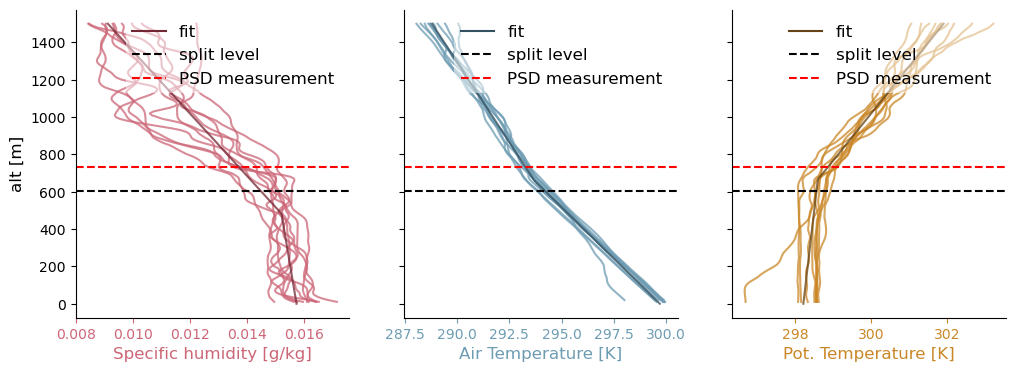

In [50]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 4), sharey=True)

scatter_style = dict(alpha=0.75)

ax_q, ax_ta, ax_theta = axs
# First plot
ax_q.plot(
    ds_dropsondes["specific_humidity"].T,
    ds_dropsondes["alt"].T,
    color=default_colors[0],
    # label="Spec. Hum.",
    **scatter_style,
)
ax_q.plot(
    thermo_fit["specific_humidity"].eval_func(ds_dropsondes["alt"])[0],
    ds_dropsondes["alt"],
    color=dark_colors[0],
    label="fit",
    **scatter_style,
)


ax_q.set_xlabel("Specific humidity [g/kg]")
ax_q.set_ylabel("alt [m]")
ax_q.xaxis.label.set_color(default_colors[0])  # Set the color of x-axis label
ax_q.tick_params(axis="x", colors=default_colors[0])  # Set the color of x-axis ticks

# Second plot on a new x-axis
ax_ta.plot(
    ds_dropsondes["air_temperature"].T,
    ds_dropsondes["alt"].T,
    color=default_colors[1],
    # label="Air Temperature",
    **scatter_style,
)
ax_ta.plot(
    thermo_fit["air_temperature"].eval_func(ds_dropsondes["alt"])[0],
    ds_dropsondes["alt"],
    color=dark_colors[1],
    label="fit",
    **scatter_style,
)

ax_ta.set_xlabel("Air Temperature [K]")
ax_ta.xaxis.label.set_color(default_colors[1])  # Set the color of x-axis label
ax_ta.tick_params(axis="x", colors=default_colors[1])  # Set the color of x-axis ticks

# Thrid plot on a new x-axis
ax_theta.plot(
    ds_dropsondes["potential_temperature"].T,
    ds_dropsondes["alt"].T,
    color=default_colors[2],
    # label="Pot. Temperature",
    **scatter_style,
)
ax_theta.plot(
    thermo_fit["potential_temperature"].eval_func(ds_dropsondes["alt"])[0],
    ds_dropsondes["alt"],
    color=dark_colors[2],
    label="fit",
    **scatter_style,
)
ax_theta.set_xlabel("Pot. Temperature [K]")
ax_theta.xaxis.label.set_color(default_colors[2])  # Set the color of x-axis label
ax_theta.tick_params(axis="x", colors=default_colors[2])  # Set the color of x-axis ticks


for ax in axs.flatten():
    ax.axhline(x_split, color="black", linestyle="--", label="split level")
    ax.axhline(ds_cloud.alt, color="red", linestyle="--", label="PSD measurement")
    ax.legend(handler_map=handler_map_alpha())


### Fix x_split

In [44]:
thermo_fit_fixed = dict(
    air_temperature = transfer.ThermodynamicSplitLinear(),
    specific_humidity = transfer.ThermodynamicSplitLinear(),
    potential_temperature = transfer.ThermodynamicSplitLinear(),
)


for var in thermo_fit:
    
    data = ds_dropsondes[var]
    alt2d = shape_dim_as_dataarray(da = data, output_dim = "alt")
    thermo_fit_fixed[var].update_individual_model_parameters(
        lmfit.Parameter(
            name = "x_split",
            value = x_split,
            vary = False
        )
    )
    result = thermo_fit_fixed[var].get_model().fit(
        data = data.data,
        x = alt2d.data,
        params = thermo_fit_fixed[var].get_model_parameters(),
        nan_policy='omit',

    )
    thermo_fit_fixed[var].lmfitParameterValues_to_dict(
        result.params
    )
print(x_split)
thermo_fit_fixed[var].get_parameters()

603.1281530413067


{'f_0': array([298.26913325]),
 'slope_1': array([0.00029587]),
 'slope_2': array([0.00380874]),
 'x_split': array([603.12815304])}

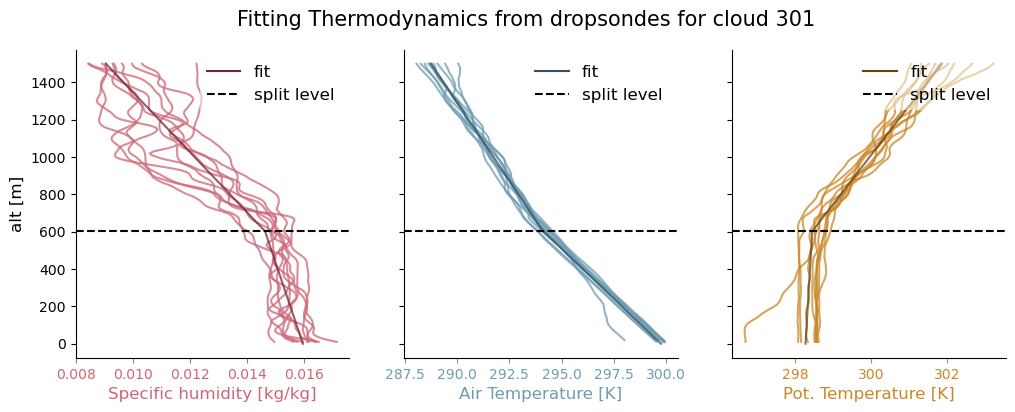

In [49]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 4), sharey=True)

scatter_style = dict(alpha=0.75)

ax_q, ax_ta, ax_theta = axs
# First plot
ax_q.plot(
    ds_dropsondes["specific_humidity"].T,
    ds_dropsondes["alt"].T,
    color=default_colors[0],
    # label="Spec. Hum.",
    **scatter_style,
)
ax_q.plot(
    thermo_fit_fixed["specific_humidity"].eval_func(ds_dropsondes["alt"])[0],
    ds_dropsondes["alt"],
    color=dark_colors[0],
    label="fit",
    **scatter_style,
)


ax_q.set_xlabel("Specific humidity [kg/kg]")
ax_q.set_ylabel("alt [m]")
ax_q.xaxis.label.set_color(default_colors[0])  # Set the color of x-axis label
ax_q.tick_params(axis="x", colors=default_colors[0])  # Set the color of x-axis ticks

# Second plot on a new x-axis
ax_ta.plot(
    ds_dropsondes["air_temperature"].T,
    ds_dropsondes["alt"].T,
    color=default_colors[1],
    # label="Air Temperature",
    **scatter_style,
)
ax_ta.plot(
    thermo_fit_fixed["air_temperature"].eval_func(ds_dropsondes["alt"])[0],
    ds_dropsondes["alt"],
    color=dark_colors[1],
    label="fit",
    **scatter_style,
)

ax_ta.set_xlabel("Air Temperature [K]")
ax_ta.xaxis.label.set_color(default_colors[1])  # Set the color of x-axis label
ax_ta.tick_params(axis="x", colors=default_colors[1])  # Set the color of x-axis ticks

# Thrid plot on a new x-axis
ax_theta.plot(
    ds_dropsondes["potential_temperature"].T,
    ds_dropsondes["alt"].T,
    color=default_colors[2],
    # label="Pot. Temperature",
    **scatter_style,
)
ax_theta.plot(
    thermo_fit_fixed["potential_temperature"].eval_func(ds_dropsondes["alt"])[0],
    ds_dropsondes["alt"],
    color=dark_colors[2],
    label="fit",
    **scatter_style,
)
ax_theta.set_xlabel("Pot. Temperature [K]")
ax_theta.xaxis.label.set_color(default_colors[2])  # Set the color of x-axis label
ax_theta.tick_params(axis="x", colors=default_colors[2])  # Set the color of x-axis ticks


for ax in axs.flatten():
    ax.axhline(x_split, color="black", linestyle="--", label="split level")
    ax.axhline(x_split, color="r", linestyle="--", label="split level")
    ax.legend(handler_map=handler_map_alpha())

fig.suptitle(f"Fitting Thermodynamics from dropsondes for cloud {chosen_id}")
fig.savefig(subfig_path / Path("fitted_thermodynamics.png"))

# Export everything as yaml

In [47]:
import yaml


def ndarray_representer(dumper: yaml.Dumper, array: np.ndarray) -> yaml.Node:
    """
    Converts a numpy ndarray to a list and represents it for YAML dumping.

    Parameters:
    dumper (yaml.Dumper): The YAML dumper instance.
    array (np.ndarray): The numpy ndarray to represent.

    Returns:
    yaml.Node: The represented list.
    """
    return dumper.represent_list(array.tolist())

def float64_representer(dumper: yaml.Dumper, array: np.float64) -> yaml.Node:
    """
    Represents a numpy float64 for YAML dumping.

    Parameters:
    dumper (yaml.Dumper): The YAML dumper instance.
    array (np.float64): The numpy float64 to represent.

    Returns:
    yaml.Node: The represented float.
    """
    return dumper.represent_float(array)

def thermofit_representer(dumper: yaml.Dumper, obj: transfer.ThermodynamicSplitLinear) -> yaml.Node:
    """
    Represents a ThermodynamicSplitLinear object for YAML dumping.

    Parameters:
    dumper (yaml.Dumper): The YAML dumper instance.
    obj (transfer.ThermodynamicSplitLinear): The ThermodynamicSplitLinear object to represent.

    Returns:
    yaml.Node: The represented dictionary of parameters.
    """
    parameters = {"slopes" : obj.get_slopes()[0]} 
    parameters.update(
        obj.get_parameters()
    )

    data = {
        "parameters" : parameters,
        "type": obj.type,


    }
    return dumper.represent_dict(data)

def psdfit_representer(dumper: yaml.Dumper, obj: transfer.PSD_LnNormal) -> yaml.Node:
    """
    Represents a PSD_LnNormal object for YAML dumping.

    Parameters:
    dumper (yaml.Dumper): The YAML dumper instance.
    obj (transfer.PSD_LnNormal): The PSD_LnNormal object to represent.

    Returns:
    yaml.Node: The represented dictionary of parameters.
    """
    data = {
        "parameters" : obj.get_parameters(),
        "type": obj.type,

    }
    return dumper.represent_dict(data)

def add_representer() -> None:
    """
    Adds custom representers for numpy ndarrays, numpy float64s, ThermodynamicSplitLinear objects, and PSD_LnNormal objects to the YAML dumper.
    """
    yaml.add_representer(np.ndarray, ndarray_representer)
    yaml.add_representer(np.float64, float64_representer)
    yaml.add_representer(transfer.ThermodynamicSplitLinear, thermofit_representer)
    yaml.add_representer(transfer.PSD_LnNormal, psdfit_representer)
add_representer()

output_dir = REPOSITORY_ROOT / "data/model/input"
output_filepath = output_dir / "example_input.yaml" 

output_dir.mkdir(parents=True, exist_ok=True)

with open(output_filepath, "w") as file:
    s = yaml.dump(dict(
        particle_size_distribution = psd_fit,
        thermodynamics = thermo_fit_fixed,
        cloud = cloud_information
    )
    )
    file.write(s)
with open(subfig_path / "input_CLEO.yaml", "w") as file:
    s = yaml.dump(dict(
        particle_size_distribution = psd_fit,
        thermodynamics = thermo_fit_fixed,
        cloud = cloud_information
    )
    )
    file.write(s)